In [5]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset

# --- CONFIGURATION 
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CHECKPOINT_DIR = '/kaggle/working/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Data Params
DATASET_NAME    = "Nan-Do/code-search-net-python"
MAX_SRC_LEN     = 50
MAX_TRG_LEN     = 80
BATCH_SIZE      = 64
# CRITICAL CHANGE: Ignore words that appear fewer than 10 times
FREQ_THRESHOLD  = 10   

# Model Params 
EMBED_DIM       = 128    
HIDDEN_DIM      = 256    
NUM_LAYERS      = 2
DROPOUT         = 0.5    
LEARNING_RATE   = 0.001
WEIGHT_DECAY    = 1e-4   
NUM_EPOCHS      = 25     
CLIP_GRAD       = 1.0

# Special Tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = '<PAD>', '<SOS>', '<EOS>', '<UNK>'

print(f"Device: {device} | Freq Threshold: {FREQ_THRESHOLD} | Dropout: {DROPOUT}")

Device: cuda | Freq Threshold: 10 | Dropout: 0.5


In [6]:
# --- TOKENIZER ---
def tokenize(text):
    text = text.strip().replace('\n', ' NEWLINE ').replace('\t', ' INDENT ')
    return re.findall(r'[a-zA-Z_][a-zA-Z0-9_]*|[0-9]+|[^\s]', text)

# --- VOCABULARY ---
class Vocabulary:
    def __init__(self):
        self.itos = {PAD_IDX:PAD_TOKEN, SOS_IDX:SOS_TOKEN, EOS_IDX:EOS_TOKEN, UNK_IDX:UNK_TOKEN}
        self.stoi = {v:k for k,v in self.itos.items()}
        
    def build(self, token_lists):
        counter = Counter()
        for t in token_lists: counter.update(t)
        idx = len(self.itos)
        for w, c in counter.most_common():
            # Uses the new global FREQ_THRESHOLD = 10
            if c >= FREQ_THRESHOLD:
                self.stoi[w] = idx; self.itos[idx] = w; idx += 1
                
    def numericalize(self, tokens):
        return [self.stoi.get(t, UNK_IDX) for t in tokens]
    
    def decode(self, indices):
        return [self.itos.get(i, UNK_TOKEN) for i in indices if i not in [PAD_IDX, SOS_IDX, EOS_IDX]]

# --- DATASET CLASS ---
class CodeDataset(Dataset):
    def __init__(self, docs, codes, sv, tv):
        self.docs, self.codes, self.sv, self.tv = docs, codes, sv, tv
    def __len__(self): return len(self.docs)
    def __getitem__(self, i):
        s = [SOS_IDX] + self.sv.numericalize(self.docs[i][:MAX_SRC_LEN]) + [EOS_IDX]
        t = [SOS_IDX] + self.tv.numericalize(self.codes[i][:MAX_TRG_LEN]) + [EOS_IDX]
        return torch.tensor(s), torch.tensor(t)

def collate_fn(batch):
    s, t = zip(*batch)
    return pad_sequence(s, batch_first=True, padding_value=PAD_IDX), \
           pad_sequence(t, batch_first=True, padding_value=PAD_IDX)

# --- LOAD DATA ---
print(f"Downloading {DATASET_NAME}...")
try:
    raw_data = load_dataset(DATASET_NAME, split='train', trust_remote_code=True)
except Exception as e:
    print(f" Nan-Do failed. Falling back to official CodeSearchNet.")
    raw_data = load_dataset("code_search_net", "python", split='train', trust_remote_code=True)

docs, codes = [], []
total_needed = 12000 

print(f"Filtering data...")
for x in raw_data:
    d = x.get('func_documentation_string') or x.get('docstring') or ''
    c = x.get('func_code_string') or x.get('code') or ''
    if d.strip() and c.strip():
        # Quick length check to avoid extremely long sequences
        d_toks = tokenize(d)
        c_toks = tokenize(c)
        if len(d_toks) < 150 and len(c_toks) < 200:
            docs.append(d_toks)
            codes.append(c_toks)
    if len(docs) >= total_needed: break

# Split
train_d, train_c = docs[:10000], codes[:10000]
val_d, val_c     = docs[10000:11000], codes[10000:11000]
test_d, test_c   = docs[11000:12000], codes[11000:12000]

# Vocab
print("Building Vocabulary (Threshold=10)...")
src_vocab = Vocabulary(); src_vocab.build(train_d)
trg_vocab = Vocabulary(); trg_vocab.build(train_c)
SRC_V_SIZE, TRG_V_SIZE = len(src_vocab.itos), len(trg_vocab.itos)

# Loaders
train_loader = DataLoader(CodeDataset(train_d, train_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(CodeDataset(val_d, val_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader  = DataLoader(CodeDataset(test_d, test_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"New Vocab Sizes: Src={SRC_V_SIZE}, Trg={TRG_V_SIZE} (Should be much smaller)")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Nan-Do/code-search-net-python' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-ee77a7de79eb2a(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

data/train-00001-of-00004-648b3bede2edf6(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

data/train-00002-of-00004-1dfd72b171e6b2(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00003-of-00004-184ab6d0e3c690(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Filtering data...
Building Vocabulary (Threshold=10)...
New Vocab Sizes: Src=2302, Trg=4691 (Should be much smaller)


In [7]:
# --- 1. VANILLA RNN ---
class VanillaRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.RNN(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.dec = nn.RNN(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc = nn.Linear(HIDDEN_DIM, TRG_V_SIZE)
        self.drop = nn.Dropout(DROPOUT)

    def forward(self, src, trg, tf=0.5):
        _, h = self.enc(self.drop(self.enc_emb(src)))
        outputs = []
        inp = trg[:, 0]
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            out, h = self.dec(emb, h)
            pred = self.fc(out.squeeze(1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)

# --- 2. LSTM ---
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.dec = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc = nn.Linear(HIDDEN_DIM, TRG_V_SIZE)
        self.drop = nn.Dropout(DROPOUT)

    def forward(self, src, trg, tf=0.5):
        _, (h, c) = self.enc(self.drop(self.enc_emb(src)))
        outputs = []
        inp = trg[:, 0]
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            out, (h, c) = self.dec(emb, (h, c))
            pred = self.fc(out.squeeze(1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)

# --- 3. ATTENTION ---
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, bidirectional=True, dropout=DROPOUT)
        self.dec = nn.LSTM(EMBED_DIM + HIDDEN_DIM*2, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc_out = nn.Linear(HIDDEN_DIM + HIDDEN_DIM*2 + EMBED_DIM, TRG_V_SIZE)
        
        self.W1 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)
        self.W2 = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM, bias=False)
        self.V = nn.Linear(HIDDEN_DIM, 1, bias=False)
        self.fc_h = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM)
        self.fc_c = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM)
        self.drop = nn.Dropout(DROPOUT)

    def calc_attn(self, hidden, enc_out, mask):
        score = torch.tanh(self.W1(hidden.unsqueeze(1)) + self.W2(enc_out))
        attn = self.V(score).squeeze(2)
        attn.masked_fill_(mask==0, -1e10)
        weights = F.softmax(attn, dim=1)
        ctx = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)
        return ctx, weights

    def forward(self, src, trg, tf=0.5):
        enc_out, (h, c) = self.enc(self.drop(self.enc_emb(src)))
        h = torch.tanh(self.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
        c = torch.tanh(self.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
        
        outputs = []
        inp = trg[:, 0]
        mask = (src != PAD_IDX)
        
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            ctx, _ = self.calc_attn(h[-1], enc_out, mask)
            rnn_in = torch.cat((emb, ctx.unsqueeze(1)), dim=2)
            out, (h, c) = self.dec(rnn_in, (h, c))
            pred = self.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)

In [11]:
def calc_accuracy(output, trg):
    preds = output.argmax(dim=1, keepdim=True).squeeze()
    mask = trg != PAD_IDX
    correct = (preds == trg) & mask
    return correct.sum().item(), mask.sum().item()

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, tf=0) 
            
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim) 
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            n_correct, n_total = calc_accuracy(output, trg)
            epoch_correct += n_correct
            epoch_total += n_total
            
    return epoch_loss / len(loader), (epoch_correct / epoch_total * 100) if epoch_total > 0 else 0

def train_model(name, model):
    print(f"\n{'='*60}\nTraining {name}\n{'='*60}")
    # ADDED WEIGHT DECAY
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    best_val_loss = float('inf')
    
    for ep in range(NUM_EPOCHS):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            output = model(src, trg, tf=0.5)
            
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
            optimizer.step()
            
            train_loss += loss.item()
            n_correct, n_total = calc_accuracy(output, trg)
            train_correct += n_correct
            train_total += n_total
            
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (train_correct / train_total) * 100 if train_total > 0 else 0
        avg_val_loss, avg_val_acc = evaluate_epoch(model, val_loader, criterion)
        
        save_msg = ""
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{name}_best.pth"))
            save_msg = " -> Saved Best"
            
        print(f"Ep {ep+1:02}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc:.2f}%{save_msg}")

# --- INIT & TRAIN ---
rnn = VanillaRNN().to(device)
lstm = LSTM().to(device)
attn = Attention().to(device)

train_model("Vanilla_RNN", rnn)
train_model("LSTM", lstm)
train_model("Attention", attn)


Training Vanilla_RNN
Ep 01/25 | Train Loss: 4.8666 Acc: 17.79% | Val Loss: 4.3175 Acc: 18.30% -> Saved Best
Ep 02/25 | Train Loss: 4.3015 Acc: 24.79% | Val Loss: 5.4038 Acc: 10.03%
Ep 03/25 | Train Loss: 4.1581 Acc: 26.44% | Val Loss: 4.4148 Acc: 16.83%
Ep 04/25 | Train Loss: 4.0780 Acc: 27.46% | Val Loss: 4.5727 Acc: 14.87%
Ep 05/25 | Train Loss: 4.0306 Acc: 28.04% | Val Loss: 4.4419 Acc: 17.00%
Ep 06/25 | Train Loss: 3.9998 Acc: 28.43% | Val Loss: 4.3906 Acc: 16.47%
Ep 07/25 | Train Loss: 3.9492 Acc: 29.15% | Val Loss: 4.4432 Acc: 16.60%
Ep 08/25 | Train Loss: 3.9197 Acc: 29.66% | Val Loss: 4.4313 Acc: 16.46%
Ep 09/25 | Train Loss: 3.8875 Acc: 30.00% | Val Loss: 4.4525 Acc: 16.56%
Ep 10/25 | Train Loss: 3.8776 Acc: 30.08% | Val Loss: 4.5591 Acc: 15.37%
Ep 11/25 | Train Loss: 3.8506 Acc: 30.35% | Val Loss: 4.4743 Acc: 16.41%
Ep 12/25 | Train Loss: 3.8574 Acc: 30.25% | Val Loss: 4.4122 Acc: 16.46%
Ep 13/25 | Train Loss: 3.8233 Acc: 30.79% | Val Loss: 5.4384 Acc: 13.07%
Ep 14/25 | Trai

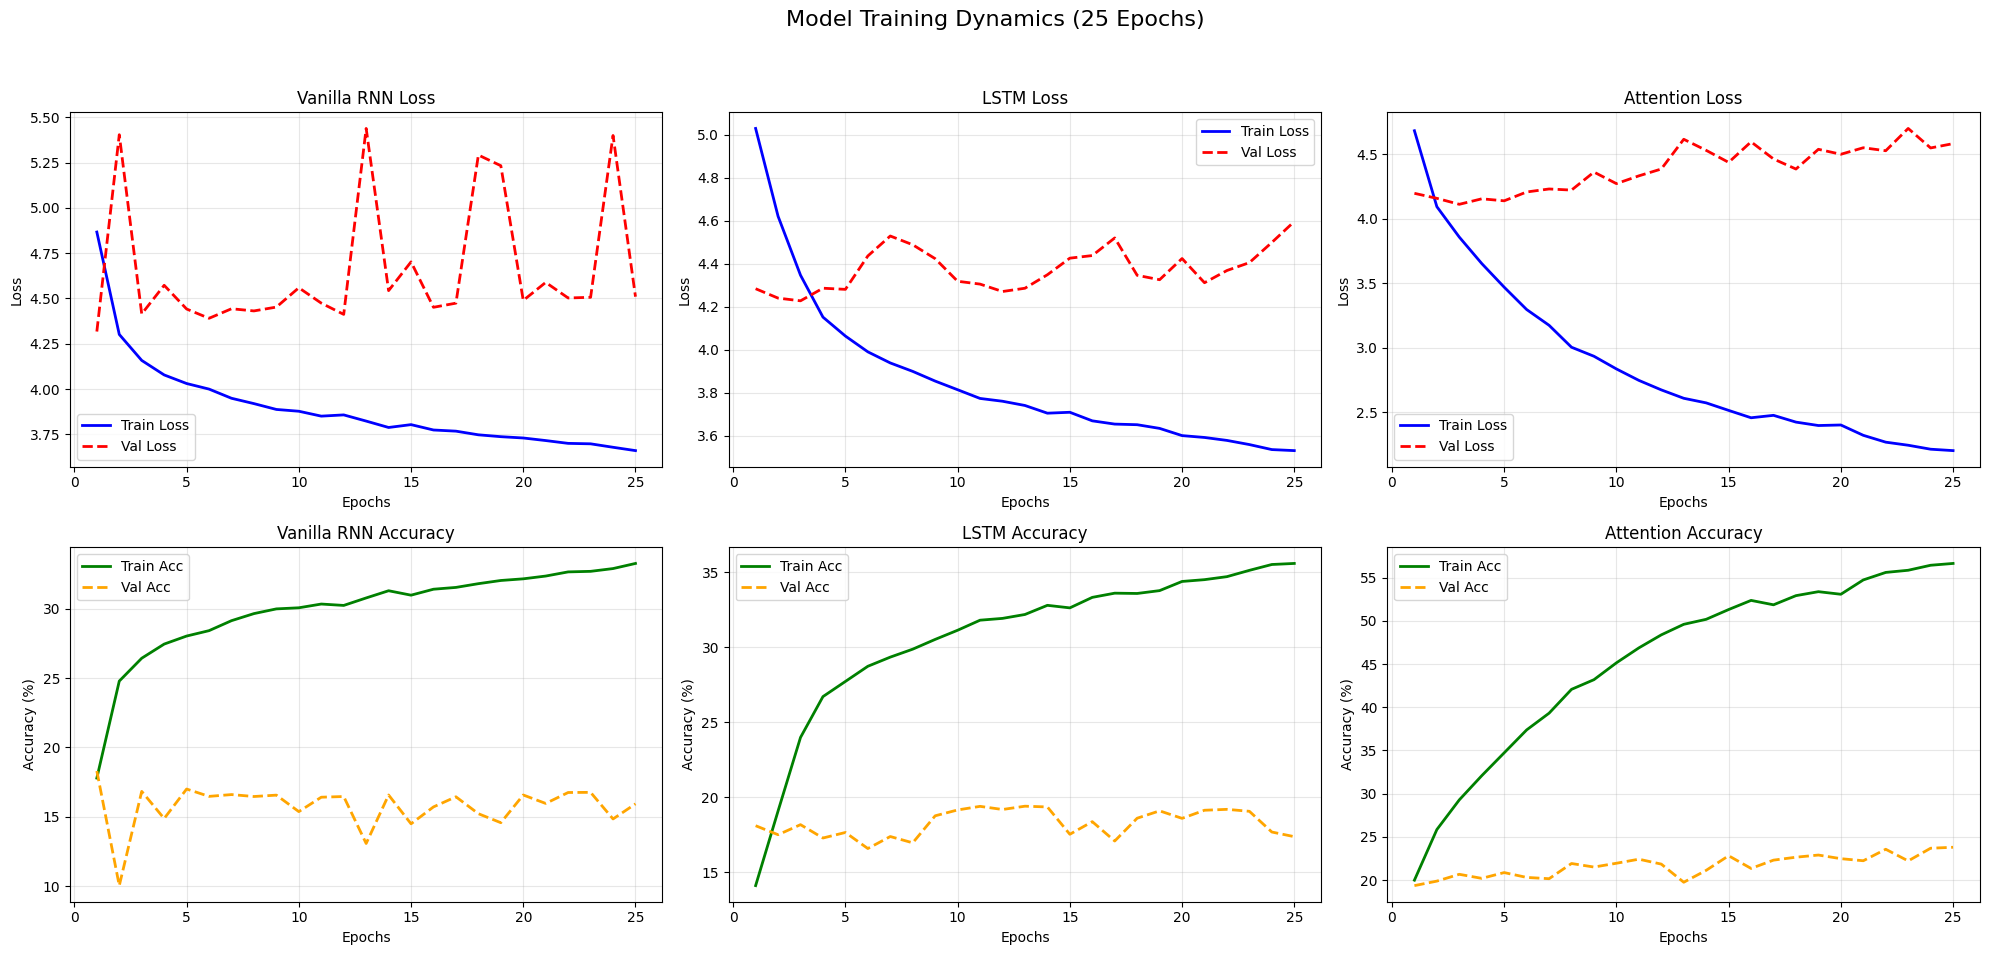

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA EXTRACTION ---

# Vanilla RNN
rnn_train_loss = [4.8666, 4.3015, 4.1581, 4.0780, 4.0306, 3.9998, 3.9492, 3.9197, 3.8875, 3.8776, 3.8506, 3.8574, 3.8233, 3.7880, 3.8037, 3.7741, 3.7677, 3.7475, 3.7372, 3.7300, 3.7158, 3.7003, 3.6978, 3.6787, 3.6603]
rnn_val_loss   = [4.3175, 5.4038, 4.4148, 4.5727, 4.4419, 4.3906, 4.4432, 4.4313, 4.4525, 4.5591, 4.4743, 4.4122, 5.4384, 4.5432, 4.7019, 4.4513, 4.4741, 5.2916, 5.2327, 4.4893, 4.5886, 4.5027, 4.5064, 5.3995, 4.5098]
rnn_train_acc  = [17.79, 24.79, 26.44, 27.46, 28.04, 28.43, 29.15, 29.66, 30.00, 30.08, 30.35, 30.25, 30.79, 31.31, 30.99, 31.42, 31.55, 31.82, 32.05, 32.17, 32.37, 32.67, 32.71, 32.91, 33.28]
rnn_val_acc    = [18.30, 10.03, 16.83, 14.87, 17.00, 16.47, 16.60, 16.46, 16.56, 15.37, 16.41, 16.46, 13.07, 16.57, 14.49, 15.71, 16.44, 15.22, 14.57, 16.57, 15.96, 16.75, 16.76, 14.84, 15.93]

# LSTM
lstm_train_loss = [5.0285, 4.6203, 4.3463, 4.1514, 4.0634, 3.9900, 3.9384, 3.8992, 3.8541, 3.8139, 3.7734, 3.7604, 3.7407, 3.7049, 3.7091, 3.6693, 3.6542, 3.6513, 3.6342, 3.6007, 3.5920, 3.5783, 3.5590, 3.5357, 3.5309]
lstm_val_loss   = [4.2834, 4.2398, 4.2272, 4.2858, 4.2805, 4.4358, 4.5285, 4.4878, 4.4231, 4.3181, 4.3049, 4.2705, 4.2857, 4.3484, 4.4255, 4.4376, 4.5195, 4.3458, 4.3253, 4.4238, 4.3113, 4.3681, 4.4047, 4.4985, 4.5958]
lstm_train_acc  = [14.12, 19.09, 23.99, 26.71, 27.72, 28.73, 29.34, 29.87, 30.52, 31.13, 31.80, 31.92, 32.18, 32.79, 32.62, 33.32, 33.60, 33.58, 33.77, 34.38, 34.50, 34.70, 35.12, 35.51, 35.58]
lstm_val_acc    = [18.11, 17.51, 18.18, 17.29, 17.66, 16.59, 17.39, 16.97, 18.77, 19.16, 19.40, 19.19, 19.41, 19.36, 17.54, 18.38, 17.09, 18.61, 19.10, 18.60, 19.14, 19.20, 19.07, 17.69, 17.38]

# Attention
attn_train_loss = [4.6837, 4.0948, 3.8589, 3.6540, 3.4706, 3.2975, 3.1751, 3.0050, 2.9351, 2.8368, 2.7481, 2.6744, 2.6093, 2.5737, 2.5154, 2.4583, 2.4771, 2.4246, 2.3981, 2.4023, 2.3222, 2.2691, 2.2453, 2.2145, 2.2036]
attn_val_loss   = [4.1984, 4.1594, 4.1132, 4.1558, 4.1403, 4.2088, 4.2321, 4.2235, 4.3630, 4.2735, 4.3338, 4.3869, 4.6174, 4.5315, 4.4384, 4.5976, 4.4647, 4.3867, 4.5397, 4.5011, 4.5517, 4.5286, 4.7014, 4.5502, 4.5836]
attn_train_acc  = [19.98, 25.84, 29.28, 32.08, 34.73, 37.38, 39.32, 42.08, 43.20, 45.15, 46.88, 48.39, 49.61, 50.19, 51.32, 52.38, 51.87, 52.93, 53.39, 53.09, 54.75, 55.62, 55.87, 56.45, 56.66]
attn_val_acc    = [19.35, 19.87, 20.66, 20.19, 20.86, 20.30, 20.15, 21.91, 21.50, 21.94, 22.41, 21.84, 19.74, 21.12, 22.81, 21.34, 22.30, 22.64, 22.89, 22.47, 22.23, 23.56, 22.21, 23.68, 23.79]

# --- 2. PLOTTING FUNCTION ---
def plot_comparative_curves():
    epochs = range(1, 26)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Model Training Dynamics (25 Epochs)', fontsize=16)
    
    models_data = [
        ("Vanilla RNN", rnn_train_loss, rnn_val_loss, rnn_train_acc, rnn_val_acc),
        ("LSTM", lstm_train_loss, lstm_val_loss, lstm_train_acc, lstm_val_acc),
        ("Attention", attn_train_loss, attn_val_loss, attn_train_acc, attn_val_acc)
    ]
    
    for i, (name, t_loss, v_loss, t_acc, v_acc) in enumerate(models_data):
        # Loss Plot
        axes[0, i].plot(epochs, t_loss, label='Train Loss', color='blue', linewidth=2)
        axes[0, i].plot(epochs, v_loss, label='Val Loss', color='red', linestyle='--', linewidth=2)
        axes[0, i].set_title(f'{name} Loss')
        axes[0, i].set_xlabel('Epochs')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].legend()
        
        # Accuracy Plot
        axes[1, i].plot(epochs, t_acc, label='Train Acc', color='green', linewidth=2)
        axes[1, i].plot(epochs, v_acc, label='Val Acc', color='orange', linestyle='--', linewidth=2)
        axes[1, i].set_title(f'{name} Accuracy')
        axes[1, i].set_xlabel('Epochs')
        axes[1, i].set_ylabel('Accuracy (%)')
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].legend()
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the plot
plot_comparative_curves()

In [12]:
def evaluate_detailed(name, model, has_attn=False):
    # Load Best Model
    path = os.path.join(CHECKPOINT_DIR, f"{name}_best.pth")
    if not os.path.exists(path): return []
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    
    refs, hyps, attn_maps = [], [], []
    correct_toks, total_toks = 0, 0
    
    print(f"\nEvaluating {name}...")
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            for i in range(src.shape[0]):
                src_seq = src[i:i+1]
                mask = (src_seq != PAD_IDX)
                
                # --- ENCODING ---
                if has_attn:
                    enc_out, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                    h = torch.tanh(model.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                    c = torch.tanh(model.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                elif isinstance(model, LSTM):
                    _, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                else:
                    _, h = model.enc(model.drop(model.enc_emb(src_seq)))
                    c = None

                # --- DECODING ---
                inp = torch.tensor([SOS_IDX], device=device)
                gen = []
                w_list = []
                
                for _ in range(MAX_TRG_LEN):
                    emb = model.drop(model.dec_emb(inp.unsqueeze(1)))
                    if has_attn:
                        ctx, w = model.calc_attn(h[-1], enc_out, mask)
                        w_list.append(w.cpu())
                        out, (h, c) = model.dec(torch.cat((emb, ctx.unsqueeze(1)), dim=2), (h, c))
                        pred = model.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    elif isinstance(model, LSTM):
                        out, (h, c) = model.dec(emb, (h, c))
                        pred = model.fc(out.squeeze(1))
                    else:
                        out, h = model.dec(emb, h)
                        pred = model.fc(out.squeeze(1))
                        
                    top = pred.argmax(1).item()
                    if top == EOS_IDX: break
                    gen.append(top)
                    inp = torch.tensor([top], device=device)
                
                # Store Text (Joined by space for readability/EM check)
                gen_text = ' '.join(trg_vocab.decode(gen))
                ref_text = ' '.join(trg_vocab.decode(trg[i].tolist()))
                
                hyps.append(gen_text)
                refs.append([ref_text])
                
                # Token Accuracy Calculation
                gen_t = trg_vocab.decode(gen)
                ref_t = trg_vocab.decode(trg[i].tolist())
                match_len = min(len(gen_t), len(ref_t))
                correct_toks += sum(1 for k in range(match_len) if gen_t[k] == ref_t[k])
                total_toks += len(ref_t)
                
                # Save Attention Map
                if has_attn and len(w_list)>0 and len(attn_maps)<3 and len(gen_t)>3:
                    attn_maps.append((src_vocab.decode(src[i].tolist()), gen_t, torch.cat(w_list).numpy()))

    # --- METRICS ---
    from nltk.translate.bleu_score import corpus_bleu
    
    # 1. BLEU (Needs list of tokens)
    tokenized_refs = [[r[0].split()] for r in refs]
    tokenized_hyps = [h.split() for h in hyps]
    bleu = corpus_bleu(tokenized_refs, tokenized_hyps) * 100
    
    # 2. Token Accuracy
    acc = (correct_toks / total_toks * 100) if total_toks > 0 else 0
    
    # 3. Exact Match (String comparison)
    em = sum([1 for r, h in zip(refs, hyps) if r[0] == h]) / len(refs) * 100
    
    print(f"Results >> BLEU: {bleu:.2f} | Token Acc: {acc:.2f}% | Exact Match: {em:.2f}%")
    return attn_maps

# Evaluate All
_ = evaluate_detailed("Vanilla_RNN", rnn)
_ = evaluate_detailed("LSTM", lstm)
maps = evaluate_detailed("Attention", attn, has_attn=True)


Evaluating Vanilla_RNN...
Results >> BLEU: 11.16 | Token Acc: 19.13% | Exact Match: 0.00%

Evaluating LSTM...
Results >> BLEU: 19.64 | Token Acc: 18.67% | Exact Match: 0.00%

Evaluating Attention...
Results >> BLEU: 21.26 | Token Acc: 21.06% | Exact Match: 0.00%
